In [1]:
import dolfinx
import numpy as np
from mpi4py import MPI
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ufl import dot, sym, grad, tr, inner, dx
from ufl import Identity, Measure, TrialFunction, TestFunction
from dolfinx.fem import functionspace, form, Function, Constant, Expression
from dolfinx.fem import dirichletbc, locate_dofs_topological, assemble_vector
from dolfinx.mesh import locate_entities_boundary, meshtags
from dolfinx.io.gmshio import read_from_msh
from dolfinx.fem.petsc import LinearProblem
from dolfinx.mesh import compute_midpoints
from scipy.spatial import KDTree

# Utility functions

In [2]:
def plot(coordinates, values, title):
    plt.figure(figsize=(10, 5))
    plt.scatter(coordinates[0], coordinates[1], 20, values, 's', 'grey', vmin=0, vmax=1)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Problem parameters

In [3]:
penalty = 3
volume_fraction = 0.5
lame_lambda, lame_mu = 1.25, 1
r = 0.02

# Reading the mesh

In [4]:
domain, _, _ = read_from_msh('domain.msh', MPI.COMM_WORLD)
dim, facets_dim = domain.geometry.dim, domain.topology.dim - 1
num_cells = domain.topology.index_map(domain.topology.dim).size_local
midpoints = compute_midpoints(domain, domain.topology.dim, np.arange(num_cells))

Info    : Reading 'rectangle.msh'...
Info    : 9 entities
Info    : 5151 nodes
Info    : 5004 elements
Info    : Done reading 'rectangle.msh'


# Prepare filter

In [5]:
def prepare_filter(coords, r):
    tree = KDTree(coords)
    distance = tree.sparse_distance_matrix(tree, r).tocsr()
    distance.data = (r - distance.data) / r
    return distance, np.array(distance.sum(1)).flatten()

In [6]:
omega, omega_sum = prepare_filter(midpoints, r)

# Boundary conditions

In [7]:
def dirichlet_boundary(x):
    return np.isclose(x[0], 0, atol=0.05)


dirichlet_value = dolfinx.default_scalar_type((0, 0, 0))

In [8]:
def neumann_boundary(x):
    return np.logical_and(np.isclose(x[0], 1, atol=0.05),
                          np.isclose(x[1], 0.25, atol=0.05))


neumann_value = dolfinx.default_scalar_type((0, -1, 0))

In [9]:
body_force_value = dolfinx.default_scalar_type((0, 0, 0))

# Strain, Stress and Strain Energy

In [10]:
def epsilon(u):
    return sym(grad(u))


def sigma(rho, u):
    return rho * (lame_lambda * tr(epsilon(u)) * Identity(len(u)) + 2 * lame_mu * epsilon(u))


def psi(rho, u, v):
    return inner(sigma(rho, u), epsilon(v))

# Continuous Function Space

In [11]:
CG1 = functionspace(domain, ('CG', 1, (dim,)))
u = TrialFunction(CG1)
v = TestFunction(CG1)

# Discrete Function Space

In [12]:
DG0 = functionspace(domain, ('DG', 0))
energy = Function(DG0, name='StrainEnergy')
rho = Function(DG0, name='Density')
rho.x.array[:] = volume_fraction

## Volume of the cells

In [13]:
volume = TestFunction(DG0)
volume_vector = assemble_vector(form(volume * dx))
volume_vector.scatter_forward()
cell_volumes = volume_vector.array

# The Finite Element problem

In [14]:
dirichlet_facets = locate_entities_boundary(domain, facets_dim, dirichlet_boundary)
dirichlet_dofs = locate_dofs_topological(CG1, facets_dim, dirichlet_facets)
dirichlet_bc = dirichletbc(dirichlet_value, dirichlet_dofs, CG1)

In [15]:
neumann_facets = locate_entities_boundary(domain, facets_dim, neumann_boundary)
facet_values = np.ones(len(neumann_facets), dtype=np.int32)
facet_tags = meshtags(domain, facets_dim, neumann_facets, facet_values)
ds = Measure('ds', domain=domain, subdomain_data=facet_tags)
neumann_bc = Constant(domain, neumann_value)

In [16]:
body_force = Constant(domain, body_force_value)

In [17]:
bilinear_form = psi(rho, u, v) * dx
linear_form = dot(body_force, v) * dx + dot(neumann_bc, v) * ds(1)
problem = LinearProblem(bilinear_form, linear_form, bcs=[dirichlet_bc],
                        petsc_options={'ksp_type': 'preonly', 'pc_type': 'cholesky'})

# Optimization

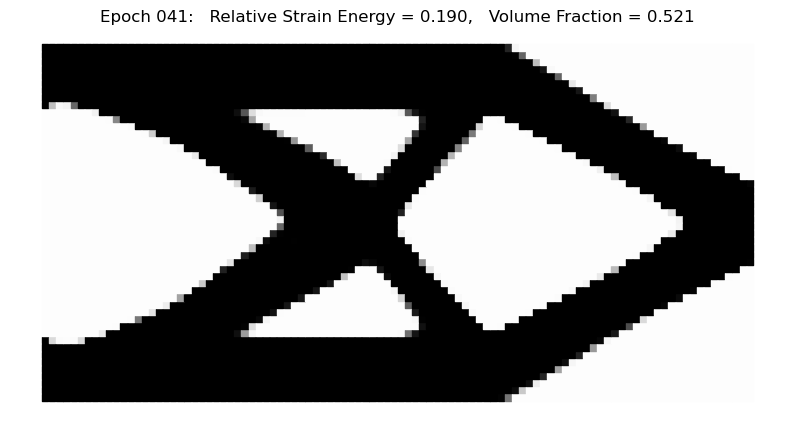

In [18]:
losses = []
x = np.full(num_cells, volume_fraction)
for epoch in range(100):
    rho.x.array[:] = (x ** penalty).flatten()  # SIMP Interpolation
    disp = problem.solve()  # Finite Element Analysis

    # Objective Function
    energy_exp = Expression(psi(rho, disp, disp), DG0.element.interpolation_points())
    energy.interpolate(energy_exp)
    losses.append(energy.x.array.sum())

    # Sensitivity Analysis
    sensitivity = - penalty * (x ** (penalty - 1)) * energy.x.array
    # Filtering the Sensitivity
    sensitivity = (omega @ sensitivity) / omega_sum

    # Optimality Criteria Method
    ocp = x * np.sqrt(-sensitivity / cell_volumes)
    l1, l2, move = 0, ocp.sum(), 0.2
    while (l2 - l1) > 1e-4:
        l_mid = 0.5 * (l2 + l1)
        x = (ocp / l_mid).clip(x - move, x + move).clip(0.01, 1)
        l1, l2 = (l_mid, l2) if x.mean() > volume_fraction else (l1, l_mid)

    clear_output(True)
    title = f'Epoch {epoch:03}:   Relative Strain Energy = {losses[-1] / losses[0]:0.3f},   Volume Fraction = {x.mean():0.3f}'
    plot(midpoints.T, 1 - x, title)

    # Checking for Convergence
    if np.logical_and(0.15 < x, x < 0.85).sum() / num_cells < 1e-2: break